In [1]:
import pandas as pd
from glob import glob

# Old dataset

In [137]:
cnt = pd.DataFrame()
for file in glob('../calibS-1/*.txt'):
  print(file)
  cnt = pd.concat([cnt,pd.read_csv(file,sep=' ', header=None,index_col=0)],axis=1)

../calibS-1/Joints.txt
../calibS-1/GearTorque.txt
../calibS-1/MeasuredPositionsLeica.txt
../calibS-1/MeasuredPositionsTS_Model.txt
../calibS-1/RobotPositions.txt
../calibS-1/DriveTorque.txt


In [144]:
cnt.columns=range(cnt.shape[1])
cnt

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,,,,,,,,,,,,,,,,,,,,,
0,94.429290,-53.369570,67.849075,4.676737,17.413774,-15.608587,0.000000,0.00000,0.0000,0.000000,...,1257.782997,-93.431758,1.529676,176.695513,0.003898,0.054700,0.011997,-0.004777,-0.002837,0.011410
1,91.151010,-52.101610,66.189760,48.378105,27.118320,-67.453530,0.000000,0.00000,0.0000,0.000000,...,1257.630117,-111.705106,0.419940,176.379760,-0.019028,-0.044321,-0.028385,-0.010518,0.000923,-0.017298
2,100.432630,-48.472008,59.058144,-52.297527,44.670227,56.954082,0.000000,0.00000,0.0000,0.000000,...,1258.022590,-56.795023,3.190011,178.263949,0.012725,-0.079608,0.004819,-0.009465,-0.006079,-0.009087
3,94.012840,-23.638317,6.143470,4.788668,91.820900,-16.738571,0.000000,0.00000,0.0000,0.000000,...,1257.803445,-100.632358,43.634065,175.310833,0.016779,0.017424,0.016787,-0.008514,-0.006572,0.010218
4,94.148890,-49.696484,88.087010,177.040050,57.309727,-188.652970,0.000000,0.00000,0.0000,0.000000,...,1257.542306,-93.468308,-49.139862,174.807088,-0.014005,0.021922,-0.021295,0.000226,-0.008891,0.011471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,117.175705,-59.779903,79.798630,-50.830210,18.732674,45.713800,63.593830,430.05590,-3398.1540,-281.328430,...,1228.093930,-98.760830,0.602824,178.536476,0.234641,-1.610079,11.831888,1.083975,0.181235,-0.071973
137,115.867810,-49.201378,54.996130,-14.165884,57.914726,18.896187,-201.595750,455.70108,-2695.3164,17.449604,...,1228.183461,-88.123909,30.195346,178.486122,-0.744513,-1.705536,9.381756,-0.065240,0.433556,-0.182495
138,121.332405,-58.264240,89.268166,-121.737330,39.902344,119.729770,-492.210240,383.26523,-2325.7795,-61.595394,...,1228.140355,-86.785652,-24.321984,178.561696,-1.841692,-1.438289,8.074601,0.228589,-0.118709,0.732410


In [139]:
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(
    cnt,
    test_size=0.3,          # Доля тестовой выборки (30%)
    random_state=42,        # Фиксируем случайность для воспроизводимости
    shuffle=True            # Перемешивание данных перед разбиением (по умолчанию True)
)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (98, 36)
Test shape: (42, 36)


In [140]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_df.loc[:,0:18], train_df.loc[:,18:23])  # y_train имеет форму (n_samples, 3)

LinearRegression()

In [141]:
predictions = model.predict(test_df.loc[:,0:18])

In [142]:
test_df.loc[:,:].head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,,,,,,,,,,,,,,,,,,,,,
108,61.806920,-53.104763,62.363480,9.456014,62.495102,-37.666634,187.07207,316.40353,-2521.4710,-62.423813,...,1188.704536,-82.892005,39.363703,178.567493,0.693030,-1.184996,8.768266,0.238716,0.518605,0.341370
67,128.384100,-41.006990,59.314450,-2.492036,67.046580,24.707090,0.00000,0.00000,0.0000,0.000000,...,811.591971,-90.666548,54.479548,179.173165,-0.021012,-0.061592,-0.021535,-0.009224,0.000468,-0.012845
31,80.176704,-41.278110,91.722790,166.641190,42.064120,-179.440020,0.00000,0.00000,0.0000,0.000000,...,635.926350,-85.183716,-21.082574,173.201796,-0.009484,0.026438,0.021700,-0.007998,-0.005395,0.010140
119,105.344990,-78.129930,111.939130,-85.528810,10.253825,81.599320,828.07970,-1536.53980,-2413.3242,-88.328210,...,1086.994272,-90.639317,3.660024,177.254659,3.043804,5.744670,8.396720,0.336079,-1.172295,-0.731475
42,114.573320,-40.498665,33.105347,-25.976200,48.153755,20.032925,0.00000,0.00000,0.0000,0.000000,...,1513.490501,-89.278699,4.944868,178.392713,-0.004936,0.048920,0.018865,0.001289,-0.002646,-0.017048


In [143]:
predictions[0]

array([ 535.92726826,  -50.53532288, 1990.55812042,  -40.59537785,
         -3.12755608,   30.20893451])

In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [57]:
mean_absolute_error(test_df.loc[:,18:23],predictions)

16.387967276919284

In [58]:
mean_squared_error(test_df.loc[:,18:23],predictions)

1810.6992396659746

In [59]:
r2_score(test_df.loc[:,18:23],predictions)

0.9197681950407818

In [60]:
corr_matrix = cnt.corr()

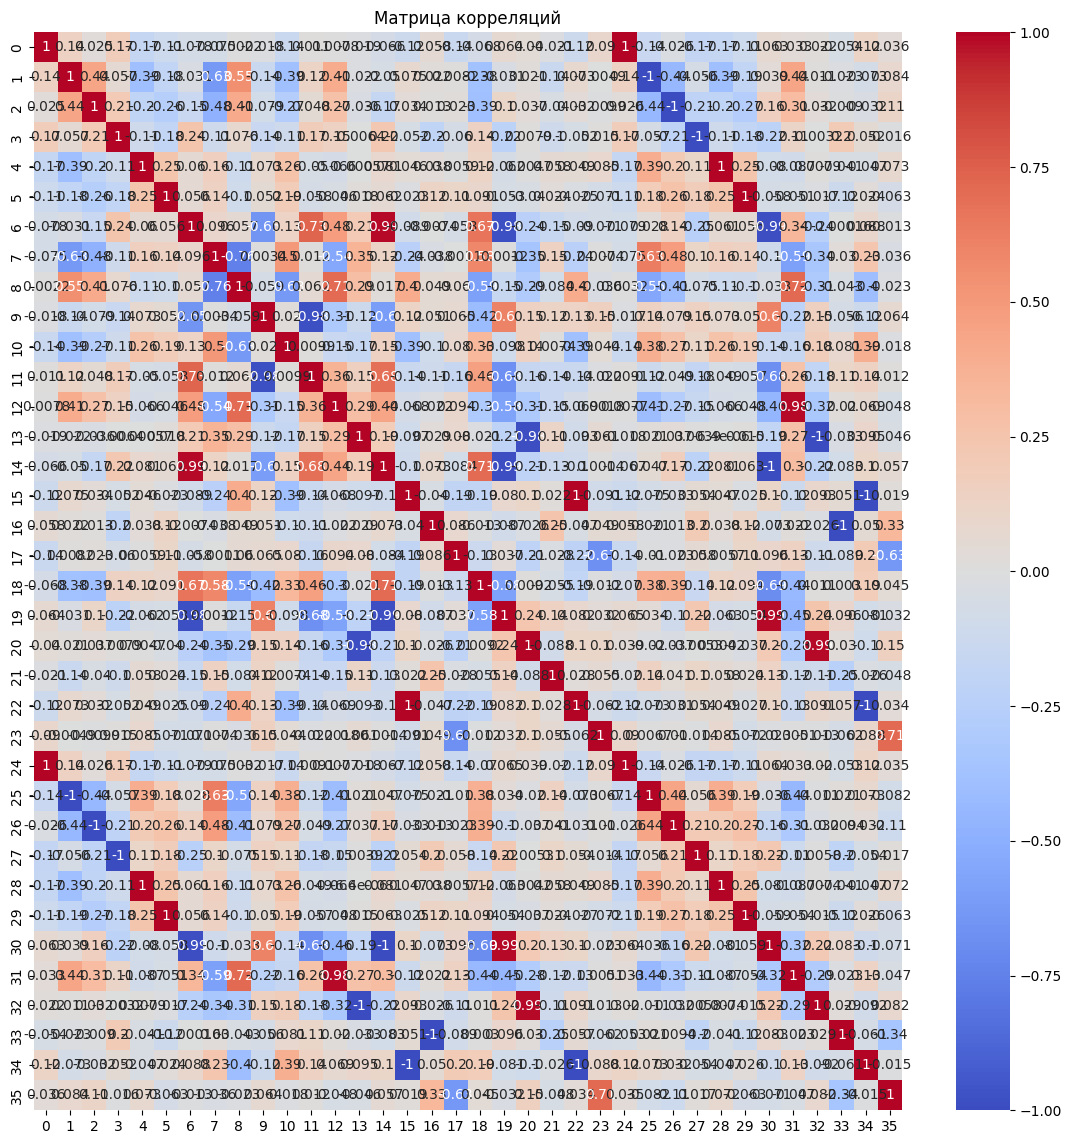

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 14))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Матрица корреляций")
plt.show()

# New  dataset

UnboundLocalError: local variable 'ind' referenced before assignment

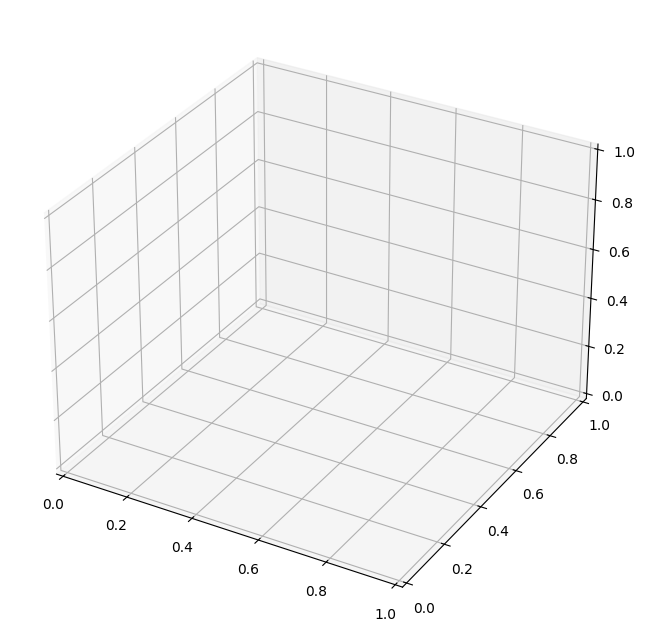

In [264]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def load_points(filename):
    """Загрузка данных из файла с обработкой BOM и разделителей"""
    # Читаем файл как текст, удаляем BOM, затем загружаем в numpy
    with open(filename, 'r', encoding='utf-8-sig') as f:  # utf-8-sig удаляет BOM
        data = np.loadtxt(f, delimiter=None)  # None - автоматическое определение разделителя
    
    positions = data[:, 1:4]  # X, Y, Z
    orientations = data[:, 4:7]  # RZ, RY, RX
    indexes = data[:, 0]
    return positions, orientations, indexes

def visualize_points(positions, orientations, indexes, scale=0.1):
    """Визуализация точек с ориентацией"""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Отображаем точки
    if ind == 529:
        ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='b', s=10, label='Точки')
    else:
        ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='r', s=10, label='Точки')
    
    # Отображаем ориентацию (векторы)
    for pos, ori, ind in zip(positions, orientations, indexes):
        # Преобразуем углы Эйлера в вектор направления
        # (упрощенное представление - можно использовать матрицы поворота для точности)
        rx, ry, rz = ori
        dx = np.cos(rz) * np.cos(ry) * scale
        dy = np.sin(rz) * np.cos(ry) * scale
        dz = np.sin(ry) * scale

        ax.quiver(pos[0], pos[1], pos[2], dx, dy, dz, color='r', length=scale, normalize=True)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Облако ориентированных точек')
    ax.legend()
    plt.show()

# Пример использования
if __name__ == "__main__":
    positions, orientations, indexes = load_points('../data/collect800Points100-20-110/RobotPositions.txt')
    visualize_points(positions, orientations, indexes)


    mesured_positions, mesured_orientations = load_points('../data/AviaStar_TestNormalizeModelV5/MeasuredPositionsTS_ModelForestNewV5.txt')
    # visualize_points(mesured_positions, mesured_orientations)


In [ ]:
import pandas as pd
import os
from tqdm import tqdm

def combine_files_with_index_check(folders, target_files, output_file=None):
    """
    Объединяет файлы с проверкой индексов
    
    Параметры:
    - folders: список путей к папкам
    - target_files: имена файлов ['DriveTorque.txt', 'GearTorque.txt', 'Joints.txt']
    - output_file: путь для сохранения (опционально)
    
    Возвращает:
    - Объединенный датафрейм (19 колонок)
    """
    
    # Результирующий датафрейм
    final_df = pd.DataFrame()
    stats = {'total_folders': 0, 'processed_folders': 0, 'errors': 0}
    
    print(f"Обработка {len(folders)} папок...")
    
    for folder in tqdm(folders):
        stats['total_folders'] += 1
        folder_data = {}
        index_ref = None
        valid_folder = True
        
        # Сначала загружаем все файлы из папки и проверяем индексы
        for file_name in target_files:
            file_path = os.path.join(folder, file_name)
            
            try:
                if os.path.exists(file_path):
                    # Чтение файла (7 колонок: индекс + 6 данных)
                    df = pd.read_csv(file_path, sep=' ', header=None, engine='python')
                    
                    # Проверка структуры файла
                    if len(df.columns) != 7:
                        print(f"\nОшибка в {file_path}: ожидается 7 колонок, получено {len(df.columns)}")
                        valid_folder = False
                        break
                        
                    # Устанавливаем индекс (первая колонка)
                    df = df.set_index(0)
                    
                    # Проверка совпадения индексов между файлами
                    if index_ref is None:
                        index_ref = df.index
                    elif not index_ref.equals(df.index):
                        print(f"\nНесовпадение индексов в {file_path}")
                        valid_folder = False
                        break
                        
                    folder_data[file_name] = df
                    
            except Exception as e:
                print(f"\nОшибка чтения {file_path}: {str(e)}")
                valid_folder = False
                break
        
        # Если все файлы загружены и индексы совпадают
        if valid_folder and len(folder_data) == len(target_files):
            try:
                # Горизонтальное объединение (6 колонок из каждого файла)
                combined = pd.concat([
                    # folder_data['DriveTorque.txt'],
                    folder_data['GearTorque.txt'],
                    folder_data['Joints.txt'],
                    folder_data['RobotPositions.txt'],
                    folder_data['MeasuredPositionsTS_Model.txt']
                ], axis=1)
                
                # Проверка количества колонок (5 файла × 6 колонок = 30)
                # if len(combined.columns) != 30:
                #     print(f"\nНеверное количество колонок в {folder}: {len(combined.columns)}")
                #     stats['errors'] += 1
                #     continue
                
                # Добавляем метку папки (19-я колонка)
                # combined['source_folder'] = os.path.basename(folder.rstrip('/'))
                
                # Добавляем к итоговому датафрейму
                final_df = pd.concat([final_df, combined], axis=0)
                stats['processed_folders'] += 1
                
            except Exception as e:
                print(f"\nОшибка объединения в {folder}: {str(e)}")
                stats['errors'] += 1
    
    # Генерация имен колонок
    if not final_df.empty:
        column_names = (
            # [f'DriveTorque_{i}' for i in range(1, 7)] +
            [f'GearTorque_{i}' for i in range(1, 7)] +
            [f'Joints_{i}' for i in range(1, 7)] +
            [f'RobotPositions_{i}' for i in range(1, 7)] +
            [f'MeasuredPositionsTS_Model_{i}' for i in range(1, 7)]
            # +['source_folder']
        )
        
        final_df.columns = column_names
        
        # Сохранение
        if output_file:
            try:
                final_df.to_csv(output_file, index=True)
                print(f"\nРезультат сохранен в {output_file}")
            except Exception as e:
                print(f"\nОшибка сохранения: {str(e)}")
    
    # Статистика
    print("\nСтатистика:")
    print(f"Успешно обработано папок: {stats['processed_folders']}/{stats['total_folders']}")
    print(f"Ошибок: {stats['errors']}")
    print(f"Итоговый размер: {final_df.shape} (ожидается 31 колонок)")
    
    return final_df

# Конфигурация
target_files = ['GearTorque.txt', 'Joints.txt', 'RobotPositions.txt', 'MeasuredPositionsTS_Model.txt']
folders = [
    '../calibS-1/',
    '../data/collect800Points100-20-110/'
    # '../data/calibF/',
    # '../data/robLocate/',
    # '../data/spiraltestS/'
]

# Запуск обработки
result = combine_files_with_index_check(
    folders=folders,
    target_files=target_files,
    output_file='combined_results.csv'
)




Обработка 2 папок...


100%|██████████| 2/2 [00:00<00:00, 11.37it/s]


Ошибка объединения в ../calibS-1/: 'MeasuredPositionsTS_ModelForest_V9, Normalized.txt'

Ошибка объединения в ../data/collect800Points100-20-110/: 'MeasuredPositionsTS_ModelForest_V9, Normalized.txt'

Статистика:
Успешно обработано папок: 0/2
Ошибок: 2
Итоговый размер: (0, 0) (ожидается 31 колонок)


 убрать наблюдение, оставить номинальные позиции

In [6]:
result.head().T

,0,1,2,3,4
GearTorque_1,382.327420,-814.275500,1020.393600,801.725770,-895.212800
GearTorque_2,841.480300,-230.767360,2120.599600,2254.055000,82.782234
GearTorque_3,-2927.655300,-2002.376500,-2859.932000,-2999.658200,-3274.505000
GearTorque_4,389.176270,406.516500,-61.812070,-43.773250,-54.015370
GearTorque_5,314.178070,411.348970,434.777340,467.070160,-313.238650
GearTorque_6,-185.917310,-234.001830,218.903720,228.940890,232.861570
Joints_1,89.933620,88.621650,90.545480,92.350220,91.742740
Joints_2,-49.793377,-50.316570,-47.438260,-44.308680,-46.455917
Joints_3,72.039080,80.929060,75.614340,69.778150,66.075325
Joints_4,-115.616070,-100.510070,-105.016556,-110.541760,-120.666340


In [7]:
result2 = result.drop(result.columns[-6:],axis=1)
# result2 = result2.drop(['RobotPositions_4','RobotPositions_5'],axis=1)
from sklearn.preprocessing import StandardScaler

cols = result2.columns
idx = result2.index

scaler = StandardScaler()
result2_scaled = pd.DataFrame(scaler.fit_transform(result2), columns=cols, index=idx)

Убрать номинальные позиции, оставить TS_Model наблюдение

In [8]:
result_laser = result.drop(result.columns[-12:-6],axis=1)
# result2 = result2.drop(['RobotPositions_4','RobotPositions_5'],axis=1)
from sklearn.preprocessing import StandardScaler

cols = result_laser.columns
idx = result_laser.index

scaler = StandardScaler()
result_laser_scaled = pd.DataFrame(scaler.fit_transform(result_laser), columns=cols, index=idx)

In [9]:
result_laser


,GearTorque_1,GearTorque_2,GearTorque_3,GearTorque_4,GearTorque_5,GearTorque_6,Joints_1,Joints_2,Joints_3,Joints_4,Joints_5,Joints_6,MeasuredPositionsTS_Model_1,MeasuredPositionsTS_Model_2,MeasuredPositionsTS_Model_3,MeasuredPositionsTS_Model_4,MeasuredPositionsTS_Model_5,MeasuredPositionsTS_Model_6
0,,,,,,,,,,,,,,,,,,
0,382.32742,841.480300,-2927.6553,389.176270,314.17807,-185.91731,89.93362,-49.793377,72.039080,-115.616070,-28.792994,89.428510,-0.001623,0.182527,1749.868022,99.998353,-19.973633,-109.985063
1,-814.27550,-230.767360,-2002.3765,406.516500,411.34897,-234.00183,88.62165,-50.316570,80.929060,-100.510070,-27.300282,71.682030,112.916253,156.123906,1750.087427,100.000921,-19.978038,-109.993670
2,1020.39360,2120.599600,-2859.9320,-61.812070,434.77734,218.90372,90.54548,-47.438260,75.614340,-105.016556,-26.202288,77.784650,0.004318,155.963442,1749.972812,99.996965,-19.958340,-109.982262
3,801.72577,2254.055000,-2999.6582,-43.773250,467.07016,228.94089,92.35022,-44.308680,69.778150,-110.541760,-25.493582,84.827225,-113.014093,156.012505,1749.961861,99.996863,-19.962114,-109.985511
4,-895.21280,82.782234,-3274.5050,-54.015370,-313.23865,232.86157,91.74274,-46.455917,66.075325,-120.666340,-28.541044,95.919490,-113.169140,0.328135,1749.931688,99.992307,-19.967159,-109.982169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,657.77606,2982.653600,-1581.9062,-626.897700,423.34216,214.77985,-153.41441,-40.239994,74.234260,115.302340,-69.956640,-73.663650,903.535359,1248.153155,5750.235032,100.031404,-19.916672,-109.979613
826,890.20350,3592.641400,-996.2073,-674.898440,434.74506,222.17130,-150.82387,-35.903340,74.383064,115.027885,-69.941230,-68.396600,1016.530723,1404.017937,5750.285957,100.033406,-19.933170,-109.981654
827,815.33417,4145.854500,-2559.6785,63.609352,-628.51404,220.71504,-148.23491,-30.995667,73.304640,115.141525,-70.104350,-63.817284,1129.434057,1560.051773,5750.431418,100.037431,-19.923418,-109.972109


In [14]:
result_laser_scaled


,GearTorque_1,GearTorque_2,GearTorque_3,GearTorque_4,GearTorque_5,GearTorque_6,Joints_1,Joints_2,Joints_3,Joints_4,Joints_5,Joints_6,MeasuredPositionsTS_Model_1,MeasuredPositionsTS_Model_2,MeasuredPositionsTS_Model_3,MeasuredPositionsTS_Model_4,MeasuredPositionsTS_Model_5,MeasuredPositionsTS_Model_6
0,,,,,,,,,,,,,,,,,,
0,0.467761,0.600225,-0.660815,1.425277,0.645201,-0.650089,-0.645420,0.908175,-0.459194,-1.751322,0.114453,1.647668,-0.040811,-0.105136,-1.853611,-0.098861,-0.373906,0.091170
1,-0.969182,0.193332,0.359715,1.485764,0.890278,-0.869073,-0.667926,0.885649,-0.131097,-1.607730,0.163162,1.469110,0.229575,0.146094,-1.853400,-0.082090,-0.413076,0.041432
2,1.233985,1.085622,-0.586120,-0.147878,0.949367,1.193521,-0.634924,1.009575,-0.327244,-1.650567,0.198991,1.530512,-0.040797,0.145835,-1.853510,-0.107926,-0.237941,0.107355
3,0.971397,1.136265,-0.740230,-0.084954,1.030814,1.239232,-0.603965,1.144320,-0.542636,-1.703088,0.222118,1.601371,-0.311424,0.145914,-1.853521,-0.108591,-0.271494,0.088584
4,-1.066375,0.312317,-1.043371,-0.120681,-0.937220,1.257087,-0.614386,1.051870,-0.679294,-1.799328,0.122674,1.712977,-0.311795,-0.104901,-1.853550,-0.138345,-0.316345,0.107893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,0.798534,1.412751,0.823470,-2.119031,0.920526,1.174741,-4.819935,1.319498,-0.378178,0.443705,-1.228777,0.006703,2.122741,1.905409,2.006744,0.116983,0.132520,0.122661
826,1.077645,1.644228,1.469463,-2.286469,0.949286,1.208402,-4.775496,1.506213,-0.372686,0.441096,-1.228274,0.059698,2.393312,2.156515,2.006793,0.130052,-0.014161,0.110870
827,0.987738,1.854160,-0.254957,0.289622,-1.732383,1.201770,-4.731083,1.717514,-0.412486,0.442176,-1.233597,0.105773,2.663663,2.407893,2.006934,0.156337,0.072545,0.166025


In [10]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.1)
    Q3 = df[column].quantile(0.9)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Применяем к нужным столбцам
for col in result_laser_scaled.columns:
    result_laser_scaled = remove_outliers_iqr(result_laser_scaled, col)

In [11]:
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(
    result_laser_scaled,
    test_size=0.3,          # Доля тестовой выборки (30%)
    random_state=42,        # Фиксируем случайность для воспроизводимости
    shuffle=True            # Перемешивание данных перед разбиением (по умолчанию True)
)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df

Train shape: (556, 18)
Test shape: (239, 18)


,GearTorque_1,GearTorque_2,GearTorque_3,GearTorque_4,GearTorque_5,GearTorque_6,Joints_1,Joints_2,Joints_3,Joints_4,Joints_5,Joints_6,MeasuredPositionsTS_Model_1,MeasuredPositionsTS_Model_2,MeasuredPositionsTS_Model_3,MeasuredPositionsTS_Model_4,MeasuredPositionsTS_Model_5,MeasuredPositionsTS_Model_6
0,,,,,,,,,,,,,,,,,,
534,-0.659547,-0.095687,-0.867106,0.251968,1.150527,-1.019101,0.528027,-0.382865,0.740173,0.397599,-0.048519,-0.299031,-0.041390,0.397608,0.559203,-0.048634,0.071138,0.019051
561,-1.390133,1.007243,-0.655892,0.469329,-0.272184,-1.035859,0.347559,0.706134,-2.463202,0.830276,-1.327042,-0.956957,-1.395639,-1.361736,0.559578,0.081488,0.406445,0.003991
441,-1.117304,0.629556,-1.048389,0.726758,-0.250088,-0.924907,0.138266,0.351278,-1.769223,0.917821,-0.889802,-1.026328,-1.395662,-1.361648,0.076879,-0.031447,0.390509,-0.076128
754,1.152136,1.560179,-0.315790,-1.700717,-1.955482,1.138976,0.895999,1.559460,-0.160434,0.245512,-0.485328,0.071900,-0.042127,2.156500,1.282873,0.022798,0.319745,0.121610
430,0.193283,0.231994,2.309026,-0.083172,-0.548165,0.355944,0.361547,-0.706379,1.993788,-0.107986,0.127251,0.242638,1.041086,0.899330,0.076796,-0.071113,-0.180767,0.055876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,-0.886832,-0.217365,0.230169,1.735117,-1.065544,-0.986820,-0.538283,0.009546,0.268590,-1.801170,0.263913,1.732482,0.229510,-0.356415,-1.371014,-0.042456,-0.316387,-0.022942
107,0.757287,0.343575,-0.847804,-0.340697,0.547220,1.184756,-0.383675,0.105184,0.624631,-1.492180,0.627065,1.433136,-0.040824,0.145606,-1.129611,-0.008083,-0.215373,0.054473
272,-0.847549,-1.437682,-0.177931,0.800332,0.430586,-0.799383,-0.307142,-1.279391,0.671131,-0.480008,2.076131,0.411875,0.770299,-0.859114,-0.647257,-0.051447,-0.232527,-0.067294


In [12]:
from sklearn.linear_model import LinearRegression

X_train = train_df.loc[:, :'Joints_6']  # Признаки (колонки 0-17)
y_train = train_df.loc[:, 'MeasuredPositionsLeica_1':]  # Целевые (колонки 18-23)
X_test = test_df.loc[:, :'Joints_6'] 
y_test = test_df.loc[:, 'MeasuredPositionsLeica_1':]


In [18]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [19]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"R² score на тренировочных данных: {train_score:.3f}")
print(f"R² score на тестовых данных: {test_score:.3f}")

R² score на тренировочных данных: 0.668
R² score на тестовых данных: 0.647


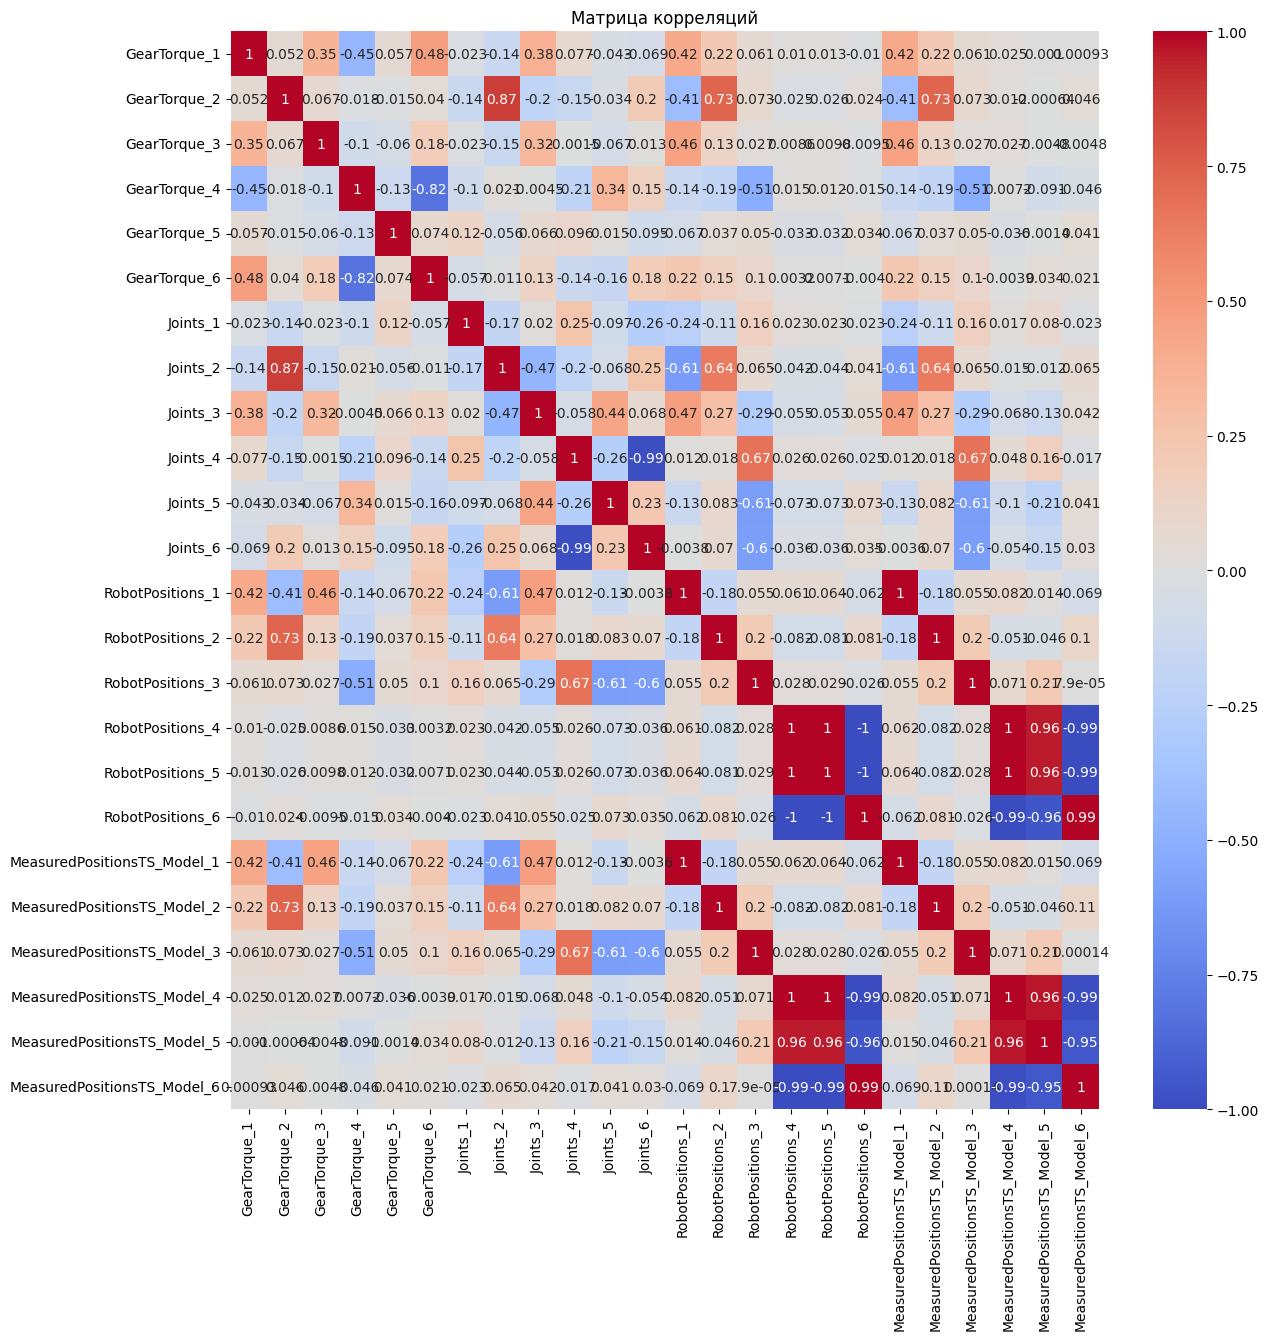

In [13]:

import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = result.corr()
plt.figure(figsize=(14, 14))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Матрица корреляций")
plt.show()

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(12, 64)   # Входной слой: 12 -> 64 нейрона
        self.fc2 = nn.Linear(64, 32)    # Скрытый слой 1: 64 -> 32 нейрона
        self.fc3 = nn.Linear(32, 16)     # Скрытый слой 2 (новый): 32 -> 16 нейронов
        self.fc4 = nn.Linear(16, 6)     # Выходной слой: 16 -> 6 нейронов

    def forward(self, x):
        x = F.relu(self.fc1(x))        # Активация ReLU после первого слоя
        x = F.relu(self.fc2(x))        # Активация ReLU после второго слоя
        x = F.relu(self.fc3(x))        # Активация ReLU после нового слоя
        x = self.fc4(x)                # Выходной слой без активации
        return x


model = SimpleModel()

In [32]:
y_train

,MeasuredPositionsTS_Model_1,MeasuredPositionsTS_Model_2,MeasuredPositionsTS_Model_3,MeasuredPositionsTS_Model_4,MeasuredPositionsTS_Model_5,MeasuredPositionsTS_Model_6
0,,,,,,
534,-0.041390,0.397608,0.559203,-0.048634,0.071138,0.019051
561,-1.395639,-1.361736,0.559578,0.081488,0.406445,0.003991
441,-1.395662,-1.361648,0.076879,-0.031447,0.390509,-0.076128
754,-0.042127,2.156500,1.282873,0.022798,0.319745,0.121610
430,1.041086,0.899330,0.076796,-0.071113,-0.180767,0.055876
...,...,...,...,...,...,...
72,0.229510,-0.356415,-1.371014,-0.042456,-0.316387,-0.022942
107,-0.040824,0.145606,-1.129611,-0.008083,-0.215373,0.054473
272,0.770299,-0.859114,-0.647257,-0.051447,-0.232527,-0.067294


In [33]:
criterion = nn.MSELoss()  # Функция потерь MSE
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Оптимизатор Adam
num_epochs = 200  # Количество эпох

In [ ]:
train_data = TensorDataset(torch.FloatTensor(X_train.to_numpy()), torch.FloatTensor(y_train.to_numpy()))
test_data = TensorDataset(torch.FloatTensor(X_test.to_numpy()), torch.FloatTensor(y_test.to_numpy()))

# Создание DataLoader
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [35]:
for epoch in range(num_epochs):
    model.train()  # Режим обучения
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Обнуляем градиенты
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass и оптимизация
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    # Вывод статистики
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Epoch 1/200, Loss: 0.4830
Epoch 2/200, Loss: 0.4285
Epoch 3/200, Loss: 0.3394
Epoch 4/200, Loss: 0.2143


Epoch 5/200, Loss: 0.1238
Epoch 6/200, Loss: 0.0895
Epoch 7/200, Loss: 0.0708
Epoch 8/200, Loss: 0.0607
Epoch 9/200, Loss: 0.0527
Epoch 10/200, Loss: 0.0462
Epoch 11/200, Loss: 0.0419
Epoch 12/200, Loss: 0.0378
Epoch 13/200, Loss: 0.0350
Epoch 14/200, Loss: 0.0316
Epoch 15/200, Loss: 0.0285
Epoch 16/200, Loss: 0.0263
Epoch 17/200, Loss: 0.0250
Epoch 18/200, Loss: 0.0223
Epoch 19/200, Loss: 0.0208
Epoch 20/200, Loss: 0.0197
Epoch 21/200, Loss: 0.0180
Epoch 22/200, Loss: 0.0169
Epoch 23/200, Loss: 0.0164
Epoch 24/200, Loss: 0.0152
Epoch 25/200, Loss: 0.0140
Epoch 26/200, Loss: 0.0142
Epoch 27/200, Loss: 0.0129
Epoch 28/200, Loss: 0.0125
Epoch 29/200, Loss: 0.0117
Epoch 30/200, Loss: 0.0113
Epoch 31/200, Loss: 0.0109
Epoch 32/200, Loss: 0.0109
Epoch 33/200, Loss: 0.0107
Epoch 34/200, Loss: 0.0107
Epoch 35/200, Loss: 0.0099
Epoch 36/200, Loss: 0.0095
Epoch 37/200, Loss: 0.0091
Epoch 38/200, Loss: 0.0088
Epoch 39/200, Loss: 0.0088
Epoch 40/200, Loss: 0.0087
Epoch 41/200, Loss: 0.0084
Epoch 

Metric               Feature 1    Feature 2    Feature 3    Feature 4   
-----------------------------------------------------------------
R2                  0.9929      0.9970      0.9978      0.7113      0.7412      0.4042      
MSE                 0.0060      0.0024      0.0021      0.0017      0.0158      0.0044      
MAE                 0.0549      0.0356      0.0346      0.0311      0.0801      0.0459      
Explained Variance  0.9929      0.9972      0.9978      0.7200      0.7413      0.4240      


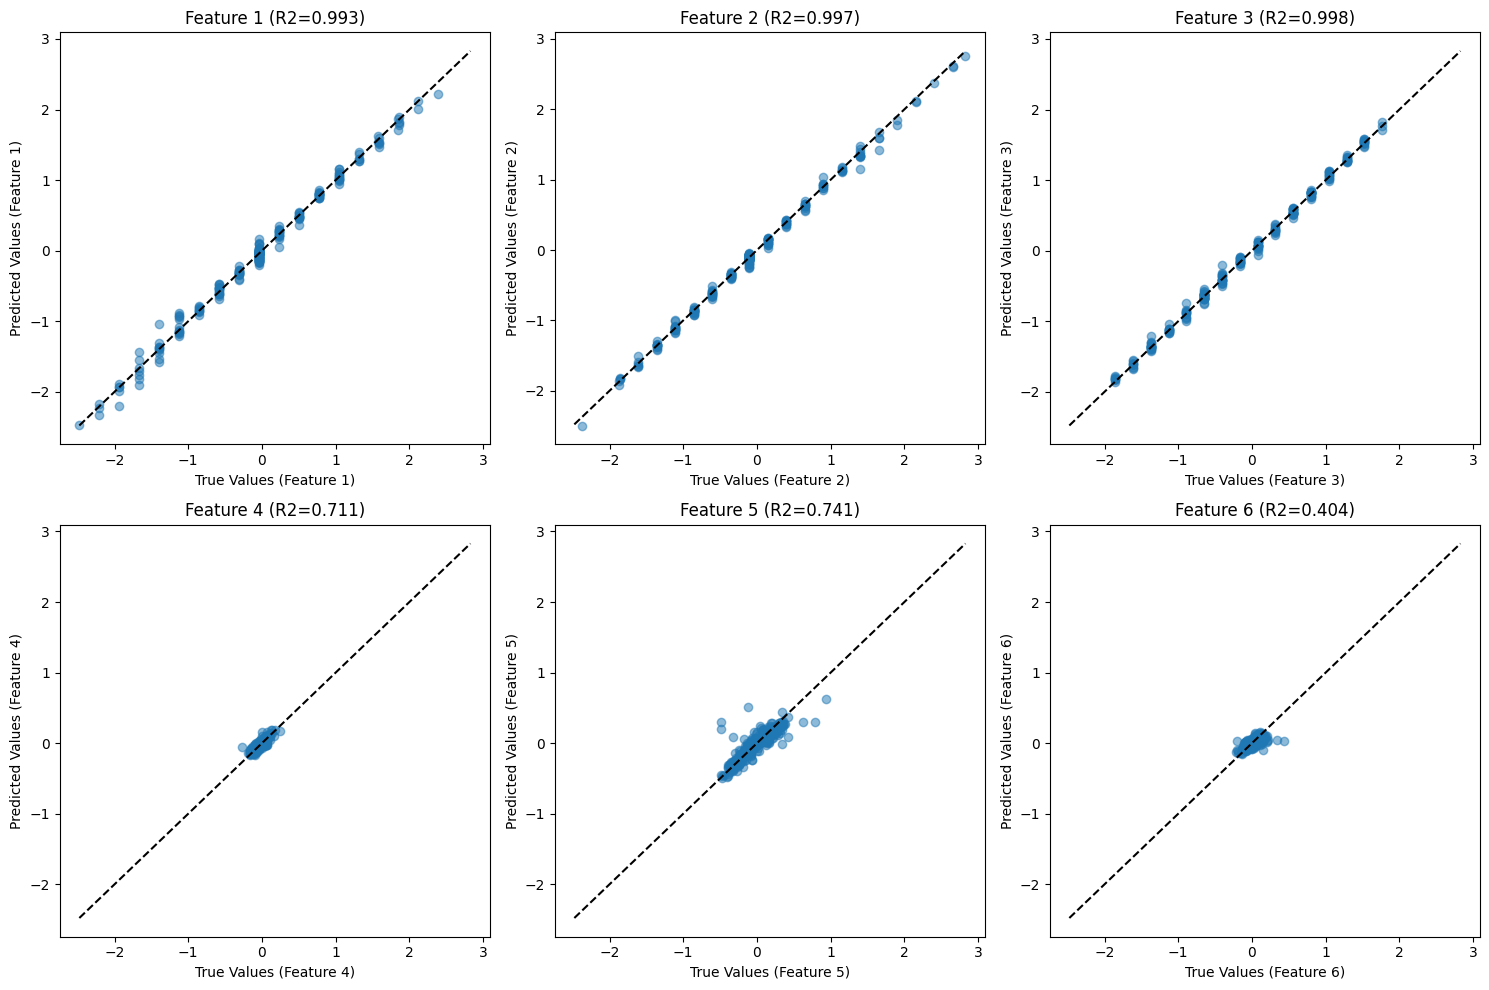


Дополнительные метрики:
Средний R2: 0.8074
Средний MSE: 0.0054
Средний MAE: 0.0470
Объясненная дисперсия: 0.8122


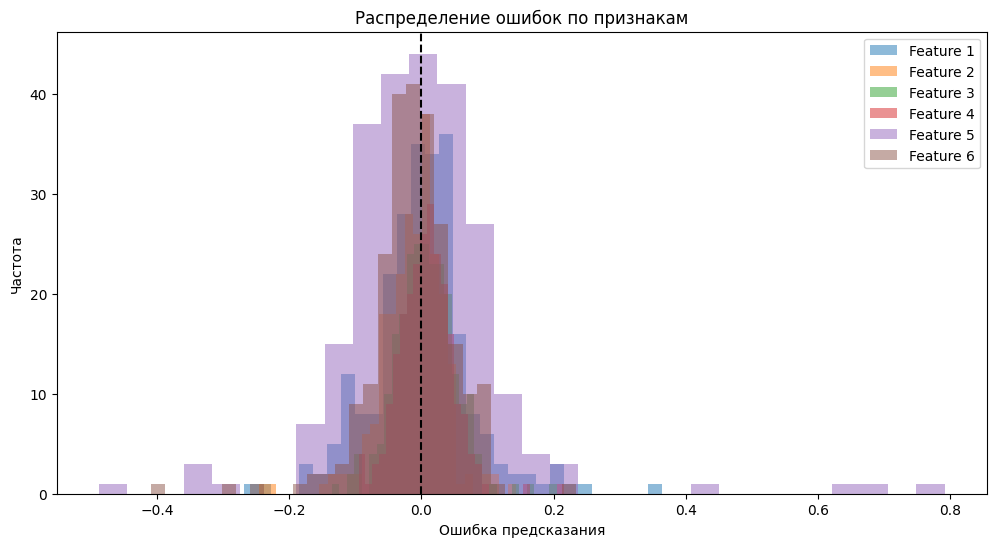

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score

# 1. Предсказание на тестовых данных
model.eval()  # Переводим модель в режим оценки
all_targets = []
all_predictions = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        all_targets.append(targets.numpy())
        all_predictions.append(outputs.numpy())

# Конвертируем в numpy массивы
y_true = np.vstack(all_targets)
y_pred = np.vstack(all_predictions)

# 2. Вычисление метрик для каждого целевого признака
metrics = {
    'R2': r2_score,
    'MSE': mean_squared_error,
    'MAE': mean_absolute_error,
    'Explained Variance': explained_variance_score
}

results = {}
for metric_name, metric_fn in metrics.items():
    results[metric_name] = [metric_fn(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])]

# 3. Вывод результатов в таблице
print(f"{'Metric':<20} {'Feature 1':<12} {'Feature 2':<12} {'Feature 3':<12} {'Feature 4':<12}")
print("-" * 65)
for metric, values in results.items():
    print(f"{metric:<20}", end="")
    for val in values:
        print(f"{val:.4f}".ljust(12), end="")
    print()

# 4. Визуализация результатов
plt.figure(figsize=(15, 10))

# График истинных vs предсказанных значений
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--')
    plt.xlabel(f'True Values (Feature {i+1})')
    plt.ylabel(f'Predicted Values (Feature {i+1})')
    plt.title(f'Feature {i+1} (R2={results["R2"][i]:.3f})')

plt.tight_layout()
plt.show()

# 5. Дополнительные метрики (по всем признакам)
print("\nДополнительные метрики:")
print(f"Средний R2: {np.mean(results['R2']):.4f}")
print(f"Средний MSE: {np.mean(results['MSE']):.4f}")
print(f"Средний MAE: {np.mean(results['MAE']):.4f}")
print(f"Объясненная дисперсия: {explained_variance_score(y_true, y_pred, multioutput='uniform_average'):.4f}")

# 6. Гистограмма ошибок
errors = y_pred - y_true
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.hist(errors[:, i], bins=30, alpha=0.5, label=f'Feature {i+1}')
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Ошибка предсказания')
plt.ylabel('Частота')
plt.title('Распределение ошибок по признакам')
plt.legend()
plt.show()